<center>
<h1> NN with hidden layers implementation </h1>
<br>
Taycir Yahmed
</center>
<br>

In [116]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import copy
from IPython.display import clear_output

if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

#####################
# Gestion des données
#####################  
import dataset_loader

#train_set, valid_set, test_set = dataset_loader.load_cifar10()
train_set, valid_set, test_set = dataset_loader.load_mnist()

def getDimDataset(train_set):

    n_training = len(train_set[1])
    n_feature = len(train_set[0][1])
    n_label = len(np.unique(train_set[1]))

    return n_training, n_feature, n_label

n_training, n_feature, n_label = getDimDataset(train_set)

########################
# Gestion des paramètres
########################

# Taille de la couche cachée: sous forme de liste, il est possible
# d'utiliser plusieurs couches cachées, avec par exemple [128, 64]
n_hidden = [100]

# Fonction d'activation: à choisir parmi 'sigmoid', 'tanh' et 'relu'
act_func = 'relu'

# Taille du batch
batch_size = 50

# Taux d'apprentissage:
eta = 0.01

# Nombre d'époques:
n_epoch = 20

In [117]:
def initNetwork(nn_arch, act_func_name):
    """
    Initialize the neural network weights, activation function and return the number of parameters
    Inputs: nn_arch: the number of units per hidden layer -  list of int
          : act_func_name: the activation function name (sigmoid, tanh or relu) - str
    Outputs: W: a list of weights for each hidden layer - list of ndarray
           : B: a list of bias for each hidden layer - list of ndarray
           : act_func: the activation function - function
           : nb_params: the number of parameters  - int
    """

    (W, B, dB_cum, dW_cum) = ([], [], [], [])
    sigma = 1.0
    act_func = globals()[act_func_name]  # Cast the string to a function
    nb_params = 0

    if act_func_name == 'sigmoid':
        sigma = 4.0

    for i in range(np.size(nn_arch) - 1):
        w = np.random.normal(loc=0.0, scale=sigma
                             / np.sqrt(nn_arch[i]), size=(nn_arch[i + 1], nn_arch[i]))
        
        dw_cum = np.zeros(w.shape)
        dW_cum.append(dw_cum)
        
        W.append(w)
        
        b = np.zeros((w.shape[0], 1))
        if act_func_name == 'sigmoid':
            b = np.sum(w, 1).reshape(-1, 1) / -2.0
        
        db_cum = np.zeros(b.shape)
        dB_cum.append(db_cum)
        
        B.append(b)
        nb_params += nn_arch[i + 1] * nn_arch[i] + nn_arch[i + 1]
    

    return (W, B, act_func, nb_params, dB_cum, dW_cum)

In [118]:
########################
# Fonctions d'activation
########################

def sigmoid(z, grad_flag=True):
    """
    Perform the sigmoid transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
           : yp: the derivatives w.r.t. z - ndarray
    """

    # compute the sigmoid y and its derivative yp

    y = 1 / (1 + np.exp(-z))

    if grad_flag:

        yp = y * (1 - y)

        return (y, yp)

    return y


def tanh(z, grad_flag=True):
    """
    Perform the tanh transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
           : yp: the derivatives w.r.t. z - ndarray
    """

    y = np.tanh(z)

    if grad_flag:

        yp = 1 - np.tanh(z) ** 2

        return (y, yp)

    return y

def relu(z, grad_flag=True):
    """
    Perform the relu transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
    """

    # compute the relu y and its derivative yp

    yp = (np.sign(z) + 1) / 2

    y = yp * z

    if grad_flag:
        return np.clip(y,-200,200), yp

    return np.clip(y,-200,200)

In [119]:
####################
# Création du réseau
####################

### Network Architecture
nn_arch = np.array([n_feature] + n_hidden + [n_label])

### Create the neural network
W, B, act_func, nb_params, dB_cum, dW_cum = initNetwork(nn_arch, act_func)

In [120]:
def forward(act_func, W, B, X):
    """
    Perform the forward propagation
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
    Outputs: Y: a list of activation values - list of ndarray
           : Yp: a list of the derivatives w.r.t. the pre-activation of the activation values - list of ndarray
    """
    
    (Y, Yp) = ([np.transpose(X)], [])

    yi = X.T

    for i in range(len(W)):
        zi = W[i].dot(yi) + B[i]

        (yi, ypi) = act_func(zi)

        Y.append(yi)
        Yp.append(ypi)

    return (Y, Yp)


In [121]:
def backward(error, W, Yp):
    """
    Perform the backward propagation
    Inputs: error: the gradient w.r.t. to the last layer - ndarray
          : W: the weights - list of ndarray
          : Yp: the derivatives w.r.t. the pre-activation of the activation functions - list of ndarray
    Outputs: gradb: a list of gradient w.r.t. the pre-activation with this order [gradb_layer1, ..., error] - list of ndarray
    """

    gradB = [error]  

    for i in range(len(W)-2, -1, -1):

        #backpropagation formula        
        derror = Yp[i]* (W[i+1].T.dot(gradB[-1]))
        gradB.append(derror)

    #inverse order [gradb_layer1, ..., error]
    gradB.reverse()    

    return gradB


In [122]:
def updateParams(theta, dtheta, eta, lamda, dtheta_cum, epsilon, regularizer=None):
    """
    Perform the update of the parameters
    Inputs: theta: the network parameters - ndarray
          : dtheta: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : regularizer: choice of the regularizer: None, 'L1', or 'L2'
          : lambda: hyperparamater giving the importance of the regularizer - float
    Outputs: the parameters updated - ndarray
    """    
    
    b = np.sqrt(dtheta_cum) + epsilon
    
    if regularizer==None:        
        
        a  = (eta /  b) * dtheta
        
        return theta - a
    
    elif regularizer=='L1':

        return (theta - (eta /  b) * dtheta) + (eta /  b) * lamda * np.sign(theta)
        
    elif regularizer=='L2':

        return (1 + (eta /  b) *lamda)*theta - (eta /  b) * dtheta 

In [123]:
def update(eta, batch_size, W, B, gradB, Y, regularizer, lamda,dW_cum, dB_cum, epsilon):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : batch_size: number of examples in the batch (for normalizing) - int
          : W: the weights - list of ndarray
          : B: the bias -  list of ndarray
          : gradB: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : Y: the activation values -  list of ndarray
    Outputs: W: the weights updated -  list of ndarray
           : B: the bias updated -  list of ndarray
    """  
   
    for i in range(len(gradB)):
        
        grad_b = (np.sum(gradB[i],axis=1)/float(batch_size)).reshape(-1,1)
        grad_w = np.array(np.dot(gradB[i], Y[i].T)) / float(batch_size)
        
        dW_cum [i] += np.square(grad_w)
        dB_cum [i] += np.square(grad_b)
        
        W[i] = updateParams(W[i], grad_w, eta,lamda, dW_cum[i], epsilon, regularizer)
        B[i] = updateParams(B[i], grad_b.reshape(-1,1), eta , lamda, dB_cum[i], epsilon, regularizer)
    
    return W, B

In [124]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
    Outputs: out: the activation values - ndarray
    """

    # compute the output of the softmax 
    
    u = np.exp( z - np.amax(z, axis=0) )
    
    return u / u.sum(axis=0)

In [125]:
def computeLoss(W, B, X, labels, act_func):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    
    ### Forward propagation
    Y, Yp = forward(act_func, W, B, X)
 
    ### Compute the softmax and the prediction
    
    out = softmax(Y[-1])
    pred = np.argmax(out,axis=0)
    
    loss = - np.log(out[labels.tolist(), np.arange(len(labels))]).sum() / len(labels)

    accuracy = (labels == pred).sum() / float(len(labels))
    
    return loss, accuracy

In [126]:
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
        Return a minibatch from the training set and the associated labels
        :param i: the identifier of the minibatch
        :param batch_size: the number of training examples
        :param train_set: the training set
        :param one_hot: the one-hot representation of the labels
        :type i: int
        :type batch_size: int
        :type train_set: ndarray
        :type ont_hot: ndarray
        :return: the minibatch of examples
        :return: the minibatch of labels
        :return: the number of examples in the minibatch
        :rtype: ndarray
        :rtype: ndarray
        :rtype: int
    """
    
    n_training = train_set[0].shape[0]
    idx_begin = i * batch_size
    idx_end = (i+1) * batch_size
    mini_batch_size = batch_size

    batch = train_set[0][idx_begin:idx_end]
    one_hot_batch = one_hot[:, idx_begin:idx_end]

    return np.asfortranarray(batch), one_hot_batch, mini_batch_size

In [127]:
def adapt_lr(previous_loss, current_loss, eta):
    
    if current_loss > previous_loss:
        eta *= 0.8
        
    else: 
        eta *= 1.2
    
    return eta

In [128]:
W0 = copy.deepcopy(W)  #a way to keep the initial W0 to ensure same conditions to compare experiements

In [129]:
W = copy.deepcopy(W0) # to make sure we have the same initialisation matrix on each experiment

In [130]:
# Data structures for plotting
g_i = []
g_train_loss=[]
g_train_acc=[]
g_valid_loss=[]
g_valid_acc=[]

#############################
### Auxiliary variables
#############################
cumul_time = 0.
n_batch = int(math.ceil(float(n_training)/batch_size))
regularizer = 'L1'
lamda = 1e-4
adaptive_lr = True
epsilon = 1e-4

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

#printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, nb_params)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta") 

#############################
### Learning process
#############################


for i in range(n_epoch):
    
    for j in range(n_batch):
     
        ### Mini-batch creation
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size, train_set, one_hot)

        prev_time = time.clock()

        ### Forward propagation
        Y, Yp = forward(act_func, W, B, batch)
            
        ### Compute the softmax
        out = softmax(Y[-1])
        
        ### Compute the gradient at the top layer
        derror = out - one_hot_batch

        ### Backpropagation
        gradB  = backward(derror, W, Yp)
        
        W, B = update(eta, batch_size, W, B, gradB, Y, regularizer, lamda, dW_cum, dB_cum, epsilon)

        curr_time = time.clock()
        cumul_time += curr_time - prev_time

    ### Training accuracy
    train_loss, train_accuracy = computeLoss(W, B, train_set[0], train_set[1], act_func) 

    ### Valid accuracy
    valid_loss, valid_accuracy = computeLoss(W, B, valid_set[0], valid_set[1], act_func) 

    g_i = np.append(g_i, i)
    g_train_loss = np.append(g_train_loss, train_loss)
    g_train_acc = np.append(g_train_acc, train_accuracy)
    g_valid_loss = np.append(g_valid_loss, valid_loss)
    g_valid_acc = np.append(g_valid_acc, valid_accuracy)
    result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_accuracy) + " " + str(valid_loss) + " " + str(valid_accuracy) + " " + str(eta)

    print(result_line)

    
    # adapting the LR
    if adaptive_lr == True:
        if i == 0:
            previous_loss = valid_loss
        else:
            eta = adapt_lr(previous_loss, valid_loss, eta)
    
    sys.stdout.flush() # Force emptying the stdout buffer

epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0 14.265014 0.248748331755 0.92886 0.235251978382 0.9352 0.01
1 27.94303 0.214881002524 0.93844 0.209943277249 0.9419 0.01
2 42.092252 0.193482249355 0.94448 0.195128050039 0.9466 0.012
3 61.250493 0.176785336308 0.94856 0.185600781269 0.9497 0.0144
4 81.063254 0.163072854538 0.9527 0.179951095704 0.9515 0.01728
5 95.745504 0.151238372594 0.9565 0.177516656953 0.9538 0.020736
6 109.844612 0.140809942316 0.95946 0.177520051489 0.9554 0.0248832
7 124.058114 0.131769875907 0.96178 0.179173810394 0.9554 0.02985984
8 138.079669 0.123933159944 0.96404 0.182734910109 0.9557 0.035831808
9 155.953959 0.117491322474 0.9661 0.187638518653 0.9547 0.0429981696
10 169.747596 0.111707440164 0.96788 0.194900768171 0.9555 0.05159780352
11 183.52413 0.107230440734 0.96924 0.201926532079 0.9546 0.061917364224
12 197.268675 0.104499981279 0.96972 0.211758333814 0.9556 0.0743008370688
13 211.146095 0.105509433667 0.96896 0.225306477808 0

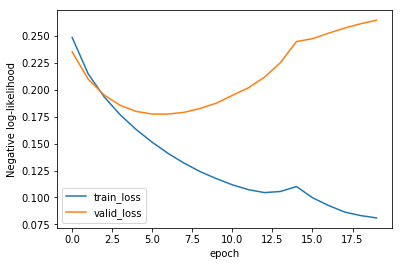

In [131]:
plt.plot(g_i,g_train_loss,label='train_loss')
plt.plot(g_i,g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

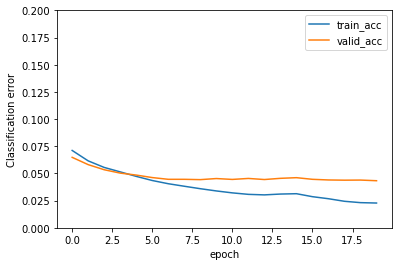

In [132]:
plt.plot(g_i,1.0-g_train_acc,label='train_acc')
plt.plot(g_i,1.0-g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,0.2])
plt.legend()